In [23]:
# How to setup d2l environment
# 1. Prepare machine, e.g. AWS EC2 instance
# 2. Install Miniconda according to the machine's Python version
#    > conda init
#    > bash
# 3. Setup conda environment using Python3.9 which is what d2l 
#    was tested on
#    > conda create d2l python==3.9
# 4. Install dependencies in conda env, i.e. torch, torchvision
#    > conda activate d2l
# 5. Download d2l notebooks
# 6. Start Jupyter notebook in d2l/pytorch. Note that jupyterlab
#    is a fancier version that support vim mode.
#    > pip install jupyterlab
#    > jupyter lab
# 7. In another window, do ssl tunneling which forward all requests
#    to local port to the specified port on remote machine
#    > ssh -i rsa.pem -L 8888:localhost:8888 user@remote_ip
# 8. Open notebook link in local browser, test
#    > import torch
#    > from d2l import torch as d2l

In [24]:
import random
import torch
from d2l import torch as d2l

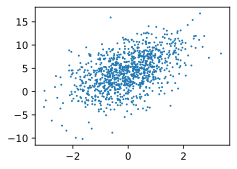

In [25]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape([-1, 1])

true_w = torch.tensor([2., -3.4])
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b, 1000)

# print(f'features: {features}, \nlabels: {labels}')

d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(),
                labels.detach().numpy(), 1)

In [26]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Use same seed to control order of examples
    random.shuffle(indices)
    
    start = 0
    while start < num_examples:
        end = min(start + batch_size, num_examples)
        batch = torch.tensor(indices[start:end])
        start = end
        yield features[batch], labels[batch]
        
batch_size = 15

for X, y in data_iter(batch_size, features, labels):
    print(f'{X}\n{y}')
    break

tensor([[-0.5115, -1.3395],
        [-0.2597, -0.1548],
        [ 1.5729, -0.8934],
        [-1.6292, -0.2581],
        [ 0.4455, -0.0023],
        [-0.3950, -1.1430],
        [ 0.4293, -0.3643],
        [ 0.7835, -0.0912],
        [-0.3406,  0.5593],
        [ 1.6586, -0.2512],
        [-0.1158,  0.7766],
        [ 0.2246, -1.1294],
        [-0.5624, -0.8467],
        [ 0.6422,  0.7430],
        [-1.4419,  0.9554]])
tensor([[ 7.7416],
        [ 4.1979],
        [10.3619],
        [ 1.8288],
        [ 5.1221],
        [ 7.3030],
        [ 6.2909],
        [ 6.0886],
        [ 1.6276],
        [ 8.3743],
        [ 1.3236],
        [ 8.4835],
        [ 5.9693],
        [ 2.9357],
        [-1.9320]])


In [27]:
# Linear regression model from scratch

def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2).sum() * 0.5

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def fit(w, b, lr, epoch, batch_size, features, labels):
    for e in range(epoch):
        for X, y in data_iter(batch_size, features, labels):
            y_hat = net(X, w, b)
            l = loss(y_hat, y)
            l.backward()
            sgd([w, b], lr, len(y_hat))
        print(f'epoch {e}, loss {l / len(y_hat):5f}')
    return w, b

lr = 0.03
epoch = 3
batch_size = 10
net = linreg
loss = squared_loss

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

w, b = fit(w, b, lr, epoch, batch_size, features, labels)
print(f'true_w: {true_w}\ntrue_b: {true_b}')
print(f'w: {w}\nb: {b}')

epoch 0, loss 0.048994
epoch 1, loss 0.000191
epoch 2, loss 0.000045
true_w: tensor([ 2.0000, -3.4000])
true_b: 4.199999809265137
w: tensor([[ 1.9989],
        [-3.4001]], requires_grad=True)
b: tensor([4.1994], requires_grad=True)


In [28]:
# Linear regression model using torch api

from torch.utils import data

def load_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

lr = 0.03
batch_size = 10
epoch = 5
# next(iter(load_data([features, labels], batch_size)))

from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

for e in range(epoch):
    for X, y in load_data([features, labels], batch_size):
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    test_l = loss(net(features), labels)
    print(f'epoch {e}, loss {test_l:5f}')
    
print(f'w: {net[0].weight.data}\nb: {net[0].bias.data}')

epoch 0, loss 0.000241
epoch 1, loss 0.000102
epoch 2, loss 0.000101
epoch 3, loss 0.000101
epoch 4, loss 0.000102
w: tensor([[ 2.0004, -3.3994]])
b: tensor([4.2004])


/home/ubuntu/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


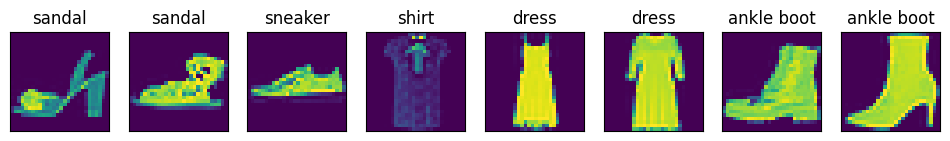

In [2]:
# Fashion Mnist data loader

import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

def get_mnist_dataloader(batch_size=18):
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
            root="data", train=True, transform=trans,
            download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
            root="data", train=False, transform=trans,
            download=True)
    
    # Fashion MNIST data structure
    # print(type(mnist_train), type(mnist_train[0]), type(mnist_train[0][0]), type(mnist_train[0][1]))
    # print(mnist_train[0][0].shape)
        
    train_loader = data.DataLoader(
            mnist_train, batch_size, shuffle=True, num_workers=4)
    test_loader = data.DataLoader(
            mnist_test, batch_size, shuffle=False, num_workers=4)
    
    return train_loader, test_loader

# # Test dataloader
batch_size = 10
train_loader, test_loader = get_mnist_dataloader(batch_size)

# # dataloader returns a BATCH of examples
# batch = next(iter(train_loader))
# batch[0].shape, batch[1].shape

def text_labels(indices):
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

def visualize(batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

batch = next(iter(train_loader))
visualize(batch)

In [33]:
# Softmax regression model from scratch

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

# y = torch.normal(0, 0.1, size=(5, 10))
# prob = softmax(y)
# print(prob, prob.sum(1))

num_inputs = 784
num_outputs = 10
w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# X is a batch of examples, i.e. a batch_size * num_inputs matrix
def softmax_net(X):
    return softmax(torch.matmul(X.reshape(-1, w.shape[0]), w) + b)

# y is a list of labels (not one hot encoded)
# y_hat is a list of softmax probs
# first get probs of the right labels, hence these labels in one hot encoding is 1
# then compute cross entropy, but no need to multiply with label value because in
# the first step they are already identified
def cross_entropy_loss(y_hat, y):
    return -torch.log(y_hat[torch.arange(len(y_hat)), y]).sum()

y = torch.tensor([0, 1, 1])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.2, 0.7, 0.1], [0.5, 0.3, 0.2]])
# cross_entropy_loss(y_hat, y),

batch_size = 3000
epoch = 3
net = softmax_net
loss = cross_entropy_loss
lr = 0.1

train_loader, test_loader = get_mnist_dataloader(batch_size)

def correct(y_hat, y):
    # y_hat is a n x 10 matrix. argmax(axis=1) finds the index of
    # the maximum value on dim 1 i.e. predicted prob.
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat == y
    return cmp.float().sum()

def train_one_epoch(train_loader, test_loader, lr):
    for X, y in train_loader:
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        sgd([w, b], lr, len(y_hat))
    
    test_l = 0
    acc = 0
    for X, trues in test_loader:
        with torch.no_grad():
            preds = net(X)
            test_l += loss(preds, trues) / len(preds)
            acc += correct(preds, trues)
    print(f'test loss {test_l:2f}, correct {acc}')    

def fit(train_loader, test_loader, epoch, lr):
    for e in range(epoch):
        train_one_epoch(train_loader, test_loader, lr)
    
fit(train_loader, test_loader, epoch, lr),

test loss 4.278353, correct 6675.0
test loss 3.569866, correct 7120.0
test loss 3.249331, correct 7357.0


(None,)

In [42]:
# Softmax regression model using torch api

import torch
import torchvision

from torch import nn

num_inputs = 784
num_outputs = 10

softmax_net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(num_inputs, num_outputs))

def init_weights(m):
    if type(m) is nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

softmax_net.apply(init_weights)

batch_size = 256
train_loader, test_loader = get_mnist_dataloader(batch_size)

net = softmax_net
loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr)

def correct(y_hat, y):
    cmp = y == torch.argmax(y_hat, 1)
    return cmp.float().sum()

def train_epoch(net, loss, optimizer, train_loader, test_loader):
    for X, y in train_loader:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
    test_l = 0
    corrects = 0
    for X, trues in test_loader:
        preds = net(X)
        l = loss(preds, trues)
        test_l += l / torch.numel(trues)
        corrects += correct(preds, trues)
    
    print(f'test loss {test_l:4f}, correct {corrects:6f}')
    
def fit(net, loss, optimizer, epoch, train_loader, test_loader):
    for e in range(epoch):
        train_epoch(net, loss, optimizer, train_loader, test_loader)
        
fit(net, loss, optimizer, epoch, train_loader, test_loader),

/home/ubuntu/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


test loss 0.123107, correct 7789.000000
test loss 0.107361, correct 8090.000000
test loss 0.105764, correct 8101.000000


(None,)

In [ ]:
# MLP model from scratch

import torch
import torchvision

batch_size = 3000
train_iter, test_iter = get_mnist_dataloader(batch_size)

# model net
num_inputs = 784
num_outputs = 10
num_hiddens = 256
w1 = torch.normal(0, 0.01, size=(num_inputs, num_hiddens),
                  requires_grad=True)
b1 = torch.zeros(size=(num_hiddens,), requires_grad=True)
w2 = torch.normal(0, 0.01, size=(num_hiddens, num_outputs),
                  requires_grad=True)
b2 = torch.zeros(size=(num_outputs,), requires_grad=True)

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

def tanh(X):
    exp = torch.exp(-2 * X)
    return (1 - exp) / (1 + exp)

def relu(X):
    zeros = torch.zeros_like(X)
    return torch.max(zeros, X)

def mlp_net(X):
    f = X.reshape(-1, num_inputs)
    h = tanh(torch.matmul(f, w1) + b1)
    o = softmax(torch.matmul(h, w2) + b2)
    return o

# loss function
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

def cross_entropy_loss(y_hat, y):
    ce = cross_entropy(y_hat, y)
    return ce.sum() / y_hat.numel()

# optimizer
def grad_zero(params):
    for param in params:
        param.grad.zero_()
    
def sgd(params, lr):
    for param in params:
        param -= lr * param.grad

# train one epoch
def correct(preds, trues):
    cmp = preds.argmax(axis=1) == trues
    return cmp.float().sum()

def fit_epoch(net, train_iter, test_iter, loss, lr, optimizer):
    params = [w1, b1, w2, b2]
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        with torch.no_grad():
            optimizer(params, lr)
            grad_zero(params)
        
    test_l = 0
    test_c = 0
    for X, trues in test_iter:
        with torch.no_grad():
            preds = net(X)
            test_l += loss(preds, trues) / torch.numel(trues)
            test_c += correct(preds, trues)
    
    return test_l, test_c

# train
net = mlp_net
loss = cross_entropy_loss
lr = 0.1
optimizer = sgd
epoch = 10

def fit(net, epoch, train_iter, test_iter, loss, lr, optimizer):
    for e in range(epoch):
        test_l, test_c = fit_epoch(net, train_iter, test_iter,
                                        loss, lr, optimizer)
        print(f'epoch {e}, loss {test_l:4f}, correct {test_c:4f}')

fit(net, epoch, train_iter, test_iter, loss, lr, optimizer),

# test

epoch 0, loss 0.000455, correct 2236.000000
epoch 1, loss 0.000449, correct 2583.000000
epoch 2, loss 0.000443, correct 3229.000000
epoch 3, loss 0.000435, correct 3862.000000
epoch 4, loss 0.000426, correct 4454.000000
